## EN.705.503.82 - AI-Enabled Systems: Local RL 

Claribel Gonell

Utilized Amazon Sagemaker examples with pre-set dqn module in attempt to directly use Blackjack. 

### Pre-requisites 

Importing relevant libraries for model configuration

In [1]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
from IPython.display import HTML
import time
from time import gmtime, strftime
import pandas as pd
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

# install gym environments if needed

from env_utils import VectoredGymEnvironment

### Setting Up S3 Bucket

Linking AWS S3 bucket links for checkpoints and metadata

In [2]:
# S3 bucket
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()
region_name = sage_session.boto_region_name
s3_output_path = "s3://{}/".format(s3_bucket)  # SDK appends the job name and output folder
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-west-2-947824586777/


### Unique Job Name for training jobs and image path for container

In [3]:
# create unique job name
job_name_prefix = "rl-batch-blackjack"

### Configuring Settings 

Local Mode: utilitzes SageMaker Python SDK to run code locally to prepare for Sagemaker deployment

In [4]:
%%time

# run in local mode?
local_mode = True

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


### Setting Up IAM Role

AWS: execution role from Sagemaker notebook
Local: uses utils method for local machine

In [5]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::947824586777:role/service-role/AmazonSageMaker-ExecutionRole-20221116T205015


### Docker installation for local mode

Common Folder has been copied into AWS Juypter notebook files which contains a setup.sh file initalizes local CPU or local CPU machine. 



In [6]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

The user has root access.
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


### Presets for RL Algorithm Configuration

Presets: Batch RL trianing job defined using a DDQ instance

1. Graph Scheduling parameters
2. Agent Parameters (DQN Agent Parameters)
3. DQN Parameters
4. Network wrapper configuration
5. ER size
6. E-Greedy Schedule
7. Enviornment = Gym Vector Environment
8. Visualization = initialized Visualization Parameters
9. Test Parameters
10. Graph Manager

In [7]:
!pygmentize src/preset-blackjack-ddqnbcq.py


from rl_coach.agents.ddqn_bcq_agent import DDQNBCQAgentParameters, KNNParameters
from rl_coach.base_parameters import PresetValidationParameters, VisualizationParameters, TaskParameters
from rl_coach.core_types import (
    CsvDataset,
    EnvironmentEpisodes,
    EnvironmentSteps,
    RunPhase,
    TrainingSteps,
)
from rl_coach.environments.gym_environment import GymVectorEnvironment, mujoco_v2
from rl_coach.graph_managers.batch_rl_graph_manager import BatchRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters
from rl_coach.memories.episodic import EpisodicExperienceReplayParameters
from rl_coach.schedules import LinearSchedule
from rl_coach.spaces import (
    DiscreteActionSpace,
    RewardSpace,
    SpacesDefinition,
    StateSpace,
    VectorObservationSpace,
)

# ####################
# # Graph Scheduling #
# ####################

schedule_params = ScheduleParameters()
# 50 epochs (we run train over all the dataset, every epoch) of training
schedule_

## Training Main()
imports environment, preset files, and defines main(). 

In [8]:
!pygmentize src/train-coach.py


import shutil

from sagemaker_rl.coach_launcher import SageMakerCoachPresetLauncher


class MyLauncher(SageMakerCoachPresetLauncher):
    def default_preset_name(self):
        """This points to a .py file that configures everything about the RL job.
        It can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter.
        """
        return "preset-blackjack-ddqnbcq"

    def map_hyperparameter(self, name, value):
        """Here we configure some shortcut names for hyperparameters that we expect to use frequently.
        Essentially anything in the preset file can be overridden through a hyperparameter with a name
        like "rl.agent_params.algorithm.etc".
        """
        # maps from alias (key) to fully qualified coach parameter (value)
        mapping = {
            "discount": "rl.agent_params.algorithm.discount",
            "evaluation_episodes": "rl.evaluation_steps:EnvironmentEpisodes",
            "improve_steps": "rl.improve_steps:TrainingStep

### Batch RL training with generated deployed policy. 

Successfully created 100 environments and generated a random policy with uniform probablities. 

The code was adapted from: https://github.com/aws/amazon-sagemaker-examples/blob/main/reinforcement_learning/rl_cartpole_batch_coach/rl_cartpole_batch_coach.ipynb

Example code: 

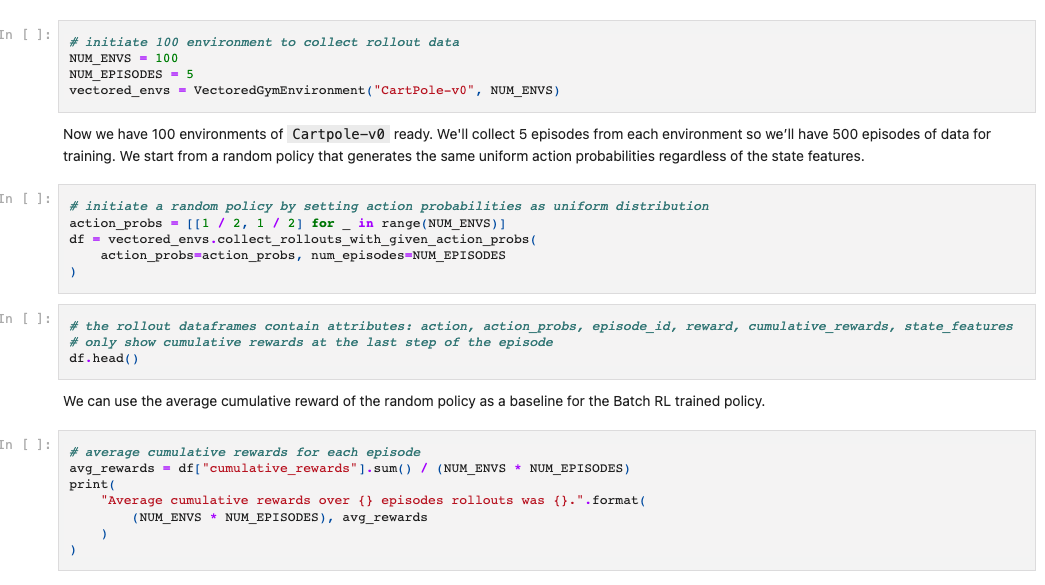

### Python SDK Script Mode Training

Will produce error due to incapable input

In [9]:
%%time

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.m4.xlarge"

estimator = RLEstimator(
    entry_point="train-coach.py",
    source_dir="src",
    dependencies=["sagemaker_rl"],
    toolkit=RLToolkit.COACH,
    toolkit_version="1.0.0",
    framework=RLFramework.TENSORFLOW,
    role=role,
    instance_type=instance_type,
    instance_count=1,
    output_path=s3_output_path,
    base_job_name=job_name_prefix,
    hyperparameters={"RLCOACH_PRESET": "preset-blackjack-ddqnbcq", "save_model": 1},
)
estimator.fit()

Creating 9pu4pir1uo-algo-1-q8lbv ... 
Creating 9pu4pir1uo-algo-1-q8lbv ... done
Attaching to 9pu4pir1uo-algo-1-q8lbv
9pu4pir1uo-algo-1-q8lbv | /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
9pu4pir1uo-algo-1-q8lbv |   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
9pu4pir1uo-algo-1-q8lbv | /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
9pu4pir1uo-algo-1-q8lbv |   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
9pu4pir1uo-algo-1-q8lbv | /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a

Failed to delete: /tmp/tmp30kiqxq6/algo-1-q8lbv Please remove it manually.


RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmp30kiqxq6/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], Process exited with code: 1

### If executed correctly, would have stored training output and model checkpoints


Necessary for metrics vizualization and model evaluation steps

In [10]:
job_name = estimator._current_job_name
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket, job_name)

if local_mode:
    output_tar_key = "{}/output.tar.gz".format(job_name)
else:
    output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))

tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: rl-batch-blackjack-2022-11-19-23-11-02-961
S3 job path: s3://sagemaker-us-west-2-947824586777/rl-batch-blackjack-2022-11-19-23-11-02-961
Output.tar.gz location: s3://sagemaker-us-west-2-947824586777/rl-batch-blackjack-2022-11-19-23-11-02-961/output.tar.gz
Intermediate folder path: s3://sagemaker-us-west-2-947824586777/rl-batch-blackjack-2022-11-19-23-11-02-961/output/intermediate/
Create local folder /tmp/rl-batch-blackjack-2022-11-19-23-11-02-961


### Plots metrics for training jobs

Off Policy Evalutation metric of training data to vizualize model performance over time. 

In [11]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

csv_file_name = "worker_0.batch_rl_graph.main_level.main_level.agent_0.csv"
key = os.path.join(intermediate_folder_key, csv_file_name)
wait_for_s3_object(s3_bucket, key, tmp_dir, training_job_name=job_name)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
df = df.dropna(subset=["Sequential Doubly Robust"])
df.dropna(subset=["Weighted Importance Sampling"])

plt.figure(figsize=(12, 5))
plt.xlabel("Number of epochs")

ax1 = df["Weighted Importance Sampling"].plot(color="blue", grid=True, label="WIS")
ax2 = df["Sequential Doubly Robust"].plot(color="red", grid=True, secondary_y=True, label="SDR")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1 + h2, l1 + l2, loc=1)
plt.show()

Waiting for s3://sagemaker-us-west-2-947824586777/rl-batch-blackjack-2022-11-19-23-11-02-961/output/intermediate/worker_0.batch_rl_graph.main_level.main_level.agent_0.csv....

ClientError: An error occurred (ValidationException) when calling the DescribeTrainingJob operation: Requested resource not found.